In [ ]:
# ==========================================
# XGBoost 주간학습 다음날 예측 (100 에포크, 조용한 출력)
# - GPU 가능시 GPU, 불가시 자동 CPU 폴백
# - train_data2.csv, test_data2.csv 사용
# - 타깃: "합산발전량(MWh)" (회귀)
# - 출력: 예측 CSV, 모델 파이프라인(pkl), 메타 JSON
# - 포함: 스케일 점검, 테스트 피처/타깃 단위 보정(강제), 정렬 일치 평가
# ==========================================
import os
import json
import warnings
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

# ---------------------------
# 0. 사용자 설정
# ---------------------------
TRAIN_PATH = r"C:\ESG_Project1\file\merge_data\train_data.csv"
TEST_PATH  = r"C:\ESG_Project1\file\merge_data\test_data.csv"
OUT_PATH = r"C:\ESG_Project1\xgboost\output"
TARGET_COL = "합산발전량(MWh)"
GROUP_KEYS = ["발전구분", "지역", "지점번호"]

OUT_PREFIX = "xgb_week2day"
RANDOM_STATE = 42
EPOCHS = 100
VAL_DAYS = 7
LEARNING_RATE = 0.05

LAG_MAX = 168
ROLL_WINDOWS = [24, 72, 168]

# ---------------------------
# 1. 유틸
# ---------------------------
def read_csv_flex(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    try:
        return pd.read_csv(path, encoding="utf-8", low_memory=False)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="cp949", low_memory=False)

def detect_datetime(df: pd.DataFrame):
    for c in ["일시", "datetime", "timestamp", "DATE_TIME", "date_time"]:
        if c in df.columns:
            dt = pd.to_datetime(df[c], errors="coerce")
            if dt.notna().any():
                df["__dt__"] = dt
                return "__dt__"
    date_cands = ["일자", "date"]
    hour_cands = ["시간", "hour", "HOUR"]
    date_col = next((c for c in date_cands if c in df.columns), None)
    hour_col = next((c for c in hour_cands if c in df.columns), None)
    if date_col and hour_col:
        h = df[hour_col].astype(str).str.extract(r"(\d{1,2})")[0].astype(float).clip(0, 23)
        df["__dt__"] = pd.to_datetime(df[date_col], errors="coerce") + pd.to_timedelta(h, unit="h")
        return "__dt__"
    return None

def add_time_features(df: pd.DataFrame, dt_col: str):
    df["hour"] = df[dt_col].dt.hour
    df["dayofweek"] = df[dt_col].dt.dayofweek
    df["month"] = df[dt_col].dt.month
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24.0)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24.0)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0)
    return df

def ensure_keys(df, keys):
    return [k for k in (keys or []) if k in df.columns]

def add_lags_and_rolls(df_all: pd.DataFrame, dt_col: str, keys, target: str):
    df_all = df_all.sort_values(ensure_keys(df_all, keys) + [dt_col] if keys else [dt_col]).copy()
    # 래그
    lag_blocks = []
    for lag in range(1, LAG_MAX + 1):
        series = (df_all.groupby(keys)[target].shift(lag) if keys
                  else df_all[target].shift(lag))
        lag_blocks.append(series.rename(f"lag_{lag}"))
    lag_df = pd.concat(lag_blocks, axis=1)
    # 롤링 (정보누수 방지: shift(1) 후 rolling)
    roll_mean_blocks, roll_std_blocks = [], []
    for w in ROLL_WINDOWS:
        if keys:
            g = df_all.groupby(keys)[target].shift(1)
            rm = g.rolling(w, min_periods=int(w*0.6)).mean()
            rs = g.rolling(w, min_periods=int(w*0.6)).std()
        else:
            rm = df_all[target].shift(1).rolling(w, min_periods=int(w*0.6)).mean()
            rs = df_all[target].shift(1).rolling(w, min_periods=int(w*0.6)).std()
        roll_mean_blocks.append(rm.rename(f"roll_mean_{w}"))
        roll_std_blocks.append(rs.rename(f"roll_std_{w}"))
    roll_df = pd.concat(roll_mean_blocks + roll_std_blocks, axis=1)
    return pd.concat([df_all, lag_df, roll_df], axis=1)

def make_onehot_encoder():
    # scikit-learn 버전 차이 호환
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

def choose_tree_method_flexible():
    """GPU 가능하면 gpu_hist, 아니면 hist로 폴백."""
    try:
        probe = XGBRegressor(
            n_estimators=1,
            max_depth=1,
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            verbosity=0,
        )
        probe.fit(np.array([[0.0, 0.0]]), np.array([0.0]))
        booster = probe.get_booster()
        pred_attr = booster.attributes().get("predictor", "")
        if "gpu" in pred_attr:
            print("✅ GPU 사용: tree_method=gpu_hist, predictor=gpu_predictor")
            return "gpu_hist", "gpu_predictor", True
    except Exception as e:
        print(f"ℹ️ GPU 미사용: {e}")
    print("➡️ CPU 사용: tree_method=hist, predictor=auto")
    return "hist", "auto", False

def _q(s):
    s = np.asarray(s, dtype=float); s = s[np.isfinite(s)]
    if s.size == 0: return {"min": None, "q50": None, "max": None}
    return dict(min=float(np.nanmin(s)), q50=float(np.nanmedian(s)), max=float(np.nanmax(s)))

def _p(a, q):
    a = np.asarray(a, dtype=float); a = a[np.isfinite(a)]
    return np.percentile(a, q) if a.size else np.nan

# ---------------------------
# 2. 데이터 로드
# ---------------------------
train = read_csv_flex(TRAIN_PATH)
test  = read_csv_flex(TEST_PATH)

dt_col_train = detect_datetime(train)
dt_col_test  = detect_datetime(test)
if dt_col_train is None or dt_col_test is None:
    raise ValueError("datetime 컬럼을 찾을 수 없습니다. (일시 또는 일자+시간 필요)")

train = add_time_features(train, dt_col_train)
test  = add_time_features(test, dt_col_test)

# ---------------------------
# 3. 히스토리 결합 후 래그/롤링 생성
# ---------------------------
all_df = pd.concat([train, test], axis=0, ignore_index=True)
all_df = add_lags_and_rolls(all_df, "__dt__", GROUP_KEYS, TARGET_COL)

# 분리
n_train = len(train)
train_df = all_df.iloc[:n_train].copy()
test_df  = all_df.iloc[n_train:].copy()

# ---------------------------
# 4. 테스트 피처/타깃 단위 보정 (강제 버전)
# ---------------------------
lag_cols  = [f"lag_{i}" for i in range(1, LAG_MAX + 1)]
roll_cols = [c for c in test_df.columns if c.startswith("roll_mean_") or c.startswith("roll_std_")]
cands = np.array([1, 10, 24, 100, 1000, 10000])

tr_p95 = _p(train_df[TARGET_COL].values, 95); tr_max = _p(train_df[TARGET_COL].values, 100)
te_p95_lag1 = _p(test_df.get("lag_1", pd.Series(np.nan, index=test_df.index)).values, 95)
te_max_lag1 = _p(test_df.get("lag_1", pd.Series(np.nan, index=test_df.index)).values, 100)

ratios = []
if np.isfinite(tr_p95) and np.isfinite(te_p95_lag1) and te_p95_lag1 > 0:
    ratios.append(tr_p95 / te_p95_lag1)
if np.isfinite(tr_max) and np.isfinite(te_max_lag1) and te_max_lag1 > 0:
    ratios.append(tr_max / te_max_lag1)

te_max_target = _p(test_df[TARGET_COL].values, 100)
if (not ratios) and np.isfinite(tr_max) and np.isfinite(te_max_target) and te_max_target > 0:
    ratios.append(tr_max / te_max_target)

raw_factor = float(np.median(ratios)) if ratios else 1.0
unit_factor = float(cands[np.argmin(np.abs(cands - raw_factor))])
if not np.isfinite(unit_factor) or unit_factor <= 0: unit_factor = 1.0

print("[TARGET scale] train:", _q(train_df[TARGET_COL].values))
print("[TARGET scale] test :", _q(test_df[TARGET_COL].values))
print(f"🔧 입력/타깃 단위 보정 배수: raw≈{raw_factor:.2f}, chosen={unit_factor:.0f}")

if unit_factor != 1.0:
    scale_cols = [c for c in lag_cols + roll_cols if c in test_df.columns]
    test_df.loc[:, scale_cols] = test_df.loc[:, scale_cols].astype(float) * unit_factor

# ---------------------------
# 5. 학습/검증 분리
# ---------------------------
valid_mask_train = train_df[lag_cols].notna().all(axis=1)
X_train = train_df.loc[valid_mask_train].drop(columns=[TARGET_COL, "__dt__"], errors="ignore")
y_train = train_df.loc[valid_mask_train, TARGET_COL].astype(float)

X_test = test_df.drop(columns=[TARGET_COL, "__dt__"], errors="ignore")
y_test = test_df[TARGET_COL] if TARGET_COL in test_df.columns else None

cutoff = train_df["__dt__"].max() - pd.Timedelta(days=VAL_DAYS)
val_mask = train_df.loc[valid_mask_train, "__dt__"] >= cutoff
X_tr, X_val = X_train.loc[~val_mask], X_train.loc[val_mask]
y_tr, y_val = y_train.loc[~val_mask], y_train.loc[val_mask]

# ---------------------------
# 6. 전처리/모델 구성 및 학습 (GPU 가능시 GPU)
# ---------------------------
tree_method, predictor, gpu_used = choose_tree_method_flexible()

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

num_tf = Pipeline([("imputer", SimpleImputer(strategy="median"))])
cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_onehot_encoder()),
])

preprocess = ColumnTransformer(
    transformers=[("num", num_tf, numeric_cols), ("cat", cat_tf, categorical_cols)],
    remainder="drop",
    sparse_threshold=0.3,
)

preprocess.fit(X_train)
X_tr_prep  = preprocess.transform(X_tr)
X_val_prep = preprocess.transform(X_val)

model = XGBRegressor(
    n_estimators=EPOCHS,
    learning_rate=LEARNING_RATE,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    tree_method=tree_method,   # 'gpu_hist' or 'hist'
    predictor=predictor,       # 'gpu_predictor' or 'auto'
    eval_metric="rmse",
    verbosity=0,
)

print(f"▶ 모델 학습 중... (라운드={EPOCHS}, 검증 구간={VAL_DAYS}일)")
model.fit(X_tr_prep, y_tr)

val_pred = model.predict(X_val_prep)
val_mae  = mean_absolute_error(y_val, val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
val_r2   = r2_score(y_val, val_pred)
print(f"[Validation] MAE={val_mae:.4f} | RMSE={val_rmse:.4f} | R2={val_r2:.4f}")

# ---------------------------
# 7. 예측/저장
# ---------------------------
X_test_prep = preprocess.transform(X_test)
test_pred = model.predict(X_test_prep)

os.makedirs(OUT_PATH, exist_ok=True)

pred_df = test.copy()
pred_df["예측합산발전량(MWh)"] = test_pred
pred_path = os.path.join(OUT_PATH, f"{OUT_PREFIX}_predictions.csv")
pred_df.to_csv(pred_path, index=False, encoding="utf-8-sig")
print(f"✅ 예측 결과 저장: {pred_path}")

# ---------------------------
# 8. 파이프라인/메타 저장 + 평가(정렬 일치, 단위 일치)
# ---------------------------
pipe = Pipeline([("preprocess", preprocess), ("model", model)])
model_path = os.path.join(OUT_PATH, f"{OUT_PREFIX}_pipeline.pkl")
joblib.dump(pipe, model_path)
print(f"✅ 모델 파이프라인 저장: {model_path}")

metrics = None
if y_test is not None and y_test.notna().any():
    eval_df = test_df[["__dt__", *ensure_keys(test_df, GROUP_KEYS), TARGET_COL]].copy()
    eval_df["y_true"] = eval_df[TARGET_COL].astype(float) * unit_factor  # 타깃만 단위 보정
    eval_df["y_pred"] = test_pred                                        # 예측값은 피처 보정 반영

    valid_lags_mask_test = test_df[lag_cols].notna().all(axis=1)
    mask_eval = np.isfinite(eval_df["y_true"]) & valid_lags_mask_test
    eval_df = eval_df[mask_eval].copy()

    mae  = mean_absolute_error(eval_df["y_true"], eval_df["y_pred"])
    rmse = np.sqrt(mean_squared_error(eval_df["y_true"], eval_df["y_pred"]))
    r2   = r2_score(eval_df["y_true"], eval_df["y_pred"])
    metrics = {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2),
               "unit_factor": float(unit_factor), "gpu_used": bool(gpu_used)}
    print(f"[Test] MAE={mae:.4f} | RMSE={rmse:.4f} | R2={r2:.4f}")
    dbg_path = os.path.join(OUT_PATH, f"{OUT_PREFIX}_debug_sample.csv")
    eval_df[["__dt__", "y_true", "y_pred"]].head(10).to_csv(dbg_path, index=False, encoding="utf-8-sig")
    print(f"🧪 디버그 샘플 저장: {dbg_path}")
else:
    print("ℹ️ 테스트 타깃이 없어 테스트 지표를 계산하지 않았습니다.")

meta = {
    "train_path": TRAIN_PATH,
    "test_path": TEST_PATH,
    "target": TARGET_COL,
    "datetime_col": "__dt__",
    "group_keys_used": ensure_keys(train, GROUP_KEYS),
    "tree_method": tree_method,
    "predictor": predictor,
    "gpu_used": bool(gpu_used),
    "lags": LAG_MAX,
    "roll_windows": ROLL_WINDOWS,
    "epochs": EPOCHS,
    "val_days": VAL_DAYS,
    "numeric_cols": X_train.select_dtypes(include=[np.number]).columns.tolist(),
    "categorical_cols": X_train.select_dtypes(exclude=[np.number]).columns.tolist(),
    "metrics_val": {"MAE": float(val_mae), "RMSE": float(val_rmse), "R2": float(val_r2)},
    "metrics_test": metrics,
}
with open(os.path.join(out_dir, f"{OUT_PREFIX}_meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("ℹ️ 메타 저장 완료")


[TARGET scale] train: {'min': 0.0, 'q50': 0.0, 'max': 55866.048}
[TARGET scale] test : {'min': 0.0, 'q50': 0.0, 'max': 5.3754}
🔧 입력/타깃 단위 보정 배수: raw≈5527.50, chosen=10000


전체 MAE 1575.849  RMSE 2892.324  R² 0.980
[INFO] 상위 1% 임계치: 10938.443, 이상치 수: 154


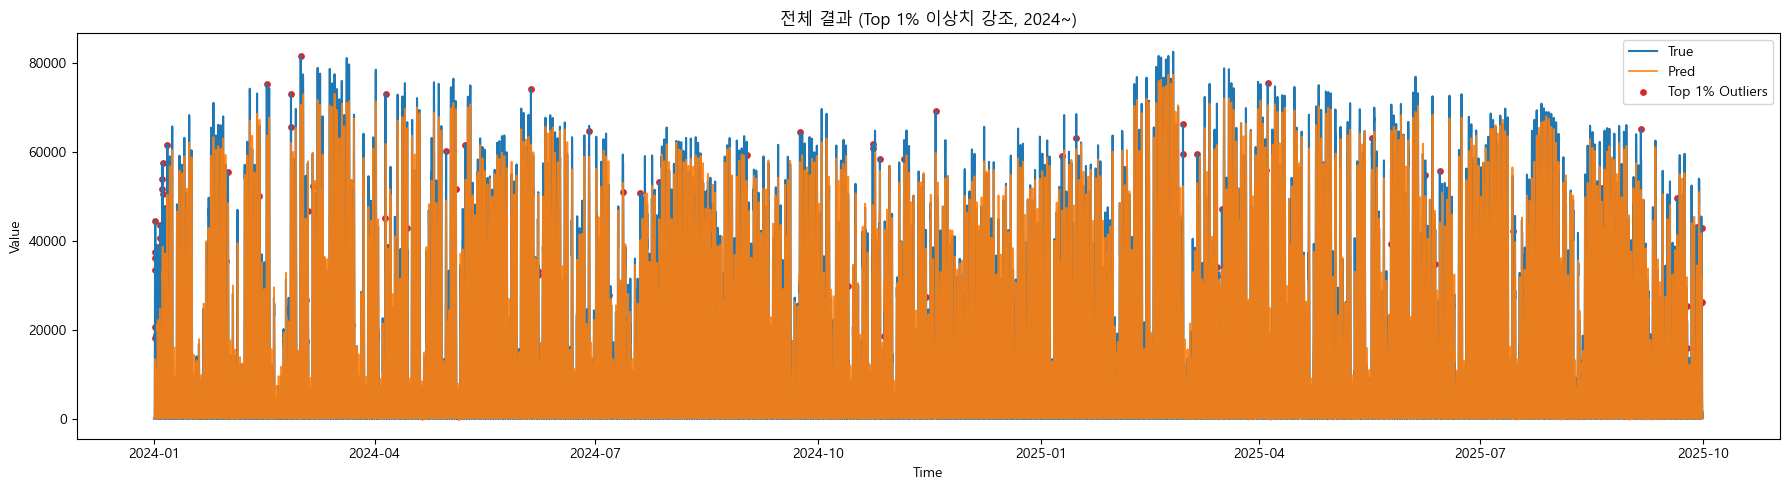

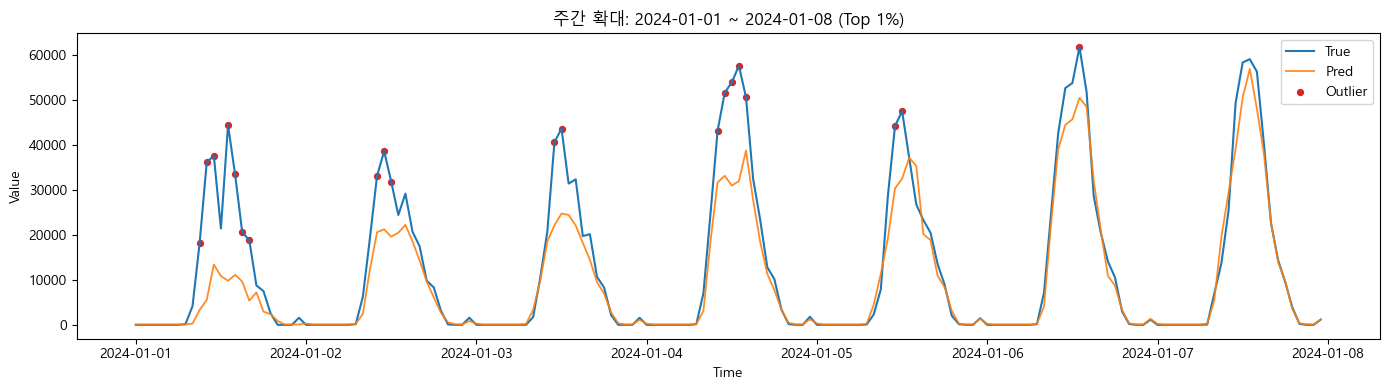

In [ ]:
# ==========================================
# 이상치 탐지 & 시각화 (Top p%)
# - unit_factor: train tail만 보정(/=)  ← ★중요
# - y_true/y_pred에는 추가 곱셈 없음(중복 방지)
# - 2024년 이후만 분석/시각화
# ==========================================
import os, json, warnings
import numpy as np
import pandas as pd
import matplotlib, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# ---------- 설정 ----------
CSV_TO_EVAL = r"C:\ESG_Project1\file\merge_data\test_data.csv"
OUT_PREFIX  = "xgb_week2day"
MODEL_PATH  = os.path.join(OUT_PATH, f"{OUT_PREFIX}_pipeline.pkl")
META_PATH   = os.path.join(OUT_PATH, f"{OUT_PREFIX}_meta.json")

TOP_P = 0.01
WEEK_START = "2024-01-01"

def _set_korean_font():
    try:
        if os.name == "nt": matplotlib.rc("font", family="Malgun Gothic")
        elif hasattr(os, "uname") and os.uname().sysname == "Darwin":
            matplotlib.rc("font", family="AppleGothic")
        matplotlib.rcParams["axes.unicode_minus"] = False
    except: pass
_set_korean_font()

def read_csv_flex(p):
    try: return pd.read_csv(p, encoding="utf-8", low_memory=False)
    except UnicodeDecodeError: return pd.read_csv(p, encoding="cp949", low_memory=False)

def detect_datetime(df):
    for c in ["일시","datetime","timestamp","DATE_TIME","date_time","__dt__"]:
        if c in df.columns:
            dt = pd.to_datetime(df[c], errors="coerce")
            if dt.notna().any():
                df["__dt__"] = dt
                return "__dt__"
    return None

def add_time_features(df, dt_col):
    df["hour"] = df[dt_col].dt.hour
    df["dayofweek"] = df[dt_col].dt.dayofweek
    df["month"] = df[dt_col].dt.month
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
    df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
    df["month_cos"] = np.cos(2*np.pi*df["month"]/12)
    return df

def ensure_keys(df, keys): 
    return [k for k in (keys or []) if k in df.columns]

def add_lags_and_rolls(df_all, dt_col, keys, target, lag_max, roll_windows):
    keys = ensure_keys(df_all, keys)
    df_all = df_all.sort_values(keys + [dt_col] if keys else [dt_col]).copy()
    g = df_all.groupby(keys) if keys else df_all.assign(_=1).groupby("_")
    for lag in range(1, lag_max+1):
        df_all[f"lag_{lag}"] = g[target].shift(lag)
    for w in roll_windows:
        df_all[f"roll_mean_{w}"] = g[target].shift(1).rolling(w, min_periods=int(w*0.6)).mean()
        df_all[f"roll_std_{w}"]  = g[target].shift(1).rolling(w, min_periods=int(w*0.6)).std()
    return df_all

# ---------- 메타 로드 ----------
with open(META_PATH, "r", encoding="utf-8") as f:
    meta = json.load(f)
TARGET_COL   = meta.get("target", "합산발전량(MWh)")
GROUP_KEYS   = meta.get("group_keys_used", [])
LAG_MAX      = int(meta.get("lags", 168))
ROLL_WINDOWS = list(meta.get("roll_windows", [24,72,168]))
TRAIN_PATH   = meta.get("train_path")
# unit_factor 없으면 1로 (추정 필요시 10000 말고 1로 두는게 안전)
UNIT_FACTOR  = float(meta.get("metrics_test", {}).get("unit_factor", 1.0) or 1.0)

# ---------- 평가 데이터 ----------
eval_df = read_csv_flex(CSV_TO_EVAL)
dt_col = detect_datetime(eval_df)
if dt_col is None: raise ValueError("datetime 컬럼을 찾을 수 없습니다.")
eval_df = add_time_features(eval_df, dt_col)

# ---------- train tail 이어붙이기 (★train tail만 /= unit_factor) ----------
if TRAIN_PATH and os.path.exists(TRAIN_PATH):
    tr = read_csv_flex(TRAIN_PATH)
    dt_tr = detect_datetime(tr)
    if dt_tr is None: raise ValueError("train_data에서 datetime 생성 실패")
    tr = add_time_features(tr, dt_tr)
    if TARGET_COL in tr.columns:
        # 학습(max≈55866), 테스트(max≈5.x)였다면 unit_factor≈10000
        # → test 스케일에 맞추려면 train tail을 나눠서 작게 만들어야 함.
        tr[TARGET_COL] = tr[TARGET_COL].astype(float) / UNIT_FACTOR
    keys = ensure_keys(eval_df, GROUP_KEYS)
    tail = tr.sort_values(keys + [dt_tr]).groupby(keys, as_index=False).tail(LAG_MAX) if keys else tr.sort_values(dt_tr).tail(LAG_MAX)
    common = list(set(tail.columns) & set(eval_df.columns))
    base = pd.concat([tail[common], eval_df[common]], ignore_index=True)
else:
    base = eval_df.copy()

# 동일 방식으로 lag/roll 생성
base = add_lags_and_rolls(base, "__dt__", GROUP_KEYS, TARGET_COL, LAG_MAX, ROLL_WINDOWS)
eval_part = base.iloc[len(base) - len(eval_df):].copy()

# ---------- 예측 (y_true/y_pred는 추가 스케일링 없음) ----------
pipe = joblib.load(MODEL_PATH)
X = eval_part.drop(columns=[c for c in [TARGET_COL, "__dt__"] if c in eval_part.columns], errors="ignore")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y_pred = pipe.predict(X)

pred = eval_part[[dt_col] + [k for k in ensure_keys(eval_part, GROUP_KEYS)]].copy()
pred["y_pred"] = y_pred
pred["y_true"] = eval_part[TARGET_COL].astype(float).values

# ---------- 2024년 이후만 집계 ----------
agg_full = pred.groupby(dt_col, as_index=False).sum(numeric_only=True).sort_values(dt_col)
agg = agg_full[agg_full[dt_col] >= pd.Timestamp("2024-01-01")].copy()

# ---------- 지표/이상치 ----------
agg["resid"] = agg["y_true"] - agg["y_pred"]
mae  = mean_absolute_error(agg["y_true"], agg["y_pred"])
rmse = np.sqrt(mean_squared_error(agg["y_true"], agg["y_pred"]))
r2   = r2_score(agg["y_true"], agg["y_pred"])
thr  = np.quantile(np.abs(agg["resid"].values), 1 - TOP_P)
agg["is_outlier"] = np.abs(agg["resid"]) >= thr

print(f"전체 MAE {mae:.3f}  RMSE {rmse:.3f}  R² {r2:.3f}")
print(f"[INFO] 상위 {int(TOP_P*100)}% 임계치: {thr:.3f}, 이상치 수: {int(agg['is_outlier'].sum())}")

# ---------- 시각화 ----------
COLOR_TRUE = "#1f77b4"; COLOR_PRED = "#ff7f0e"; COLOR_OUTL = "#d62728"

plt.figure(figsize=(18,5))
plt.plot(agg[dt_col], agg["y_true"], label="True", linewidth=1.5, color=COLOR_TRUE)
plt.plot(agg[dt_col], agg["y_pred"], label="Pred", linewidth=1.3, color=COLOR_PRED, alpha=0.9)
out = agg[agg["is_outlier"]]
plt.scatter(out[dt_col], out["y_true"], s=15, color=COLOR_OUTL, label=f"Top {int(TOP_P*100)}% Outliers")
plt.title(f"전체 결과 (Top {int(TOP_P*100)}% 이상치 강조, 2024~)")
plt.xlabel("Time"); plt.ylabel("Value"); plt.legend(); plt.tight_layout(); plt.show()

start = pd.to_datetime(WEEK_START).normalize()
end = start + pd.Timedelta(days=7)
week = agg[(agg[dt_col] >= start) & (agg[dt_col] < end)]
plt.figure(figsize=(14,4))
plt.plot(week[dt_col], week["y_true"], label="True", linewidth=1.5, color=COLOR_TRUE)
plt.plot(week[dt_col], week["y_pred"], label="Pred", linewidth=1.3, color=COLOR_PRED, alpha=0.9)
wk_out = week[week["is_outlier"]]
plt.scatter(wk_out[dt_col], wk_out["y_true"], s=18, color=COLOR_OUTL, label="Outlier")
plt.title(f"주간 확대: {start.date()} ~ {end.date()} (Top {int(TOP_P*100)}%)")
plt.xlabel("Time"); plt.ylabel("Value"); plt.legend(); plt.tight_layout(); plt.show()
